# TD IVIM : Pré-traitement d'images cardiaques #

Le pré-traitement est une étape fondamentale pour l'analyse d'images médicales afin d'homogénéiser une base de données ( contrast, valeurs extrêmes, dimensions etc... ) et / ou de simplifier un problème ( isolement d'une région d'intérêt, atténuation d'artéfacts, extraction de caractéristiques "features" etc... ). Ce faisant, on retrouve des méthodes de pré-traitement dédiées à des modalités d'images ( IRM, US, CT ... ), des régions ( organes, tissus ... ) et des applications ( segmentation, classification, détection etc... ).

Le but de ce TD-TP est de se familiariser avec les spécificités du pré-traitement d'images médicales à l'aide d'une application classique, l'imagerie cardiaque, pour laquelle une base de données publiques en imagerie ultrasonore est présentée. Nous utiliserons Python, un langage de programmation très utilisé en traitement d'image et science des données, y compris dans le domaine médical.

## I. Imagerie ultrasonore ##

L'imagerie ultrasonore est privilégiée en cardiologie pour effectuer le pré-diagnostique cardiaque car elle possède une haute résolution temporelle (adaptée à l'étude d'un organe dynamique) et que l'examen est à la fois rapide et peu coûteux. 

#### CAMUS dataset ####

La base de données CAMUS (Cardiac Acquisitions for Multi-Structure Ultrasound image Segmentation) contient les vues apicales 2 chambres (2CH) et 4 chambres (4CH) d'au moins un cycle cardiaque de 500 patients. Les instants de fin diastole (ED) et de fin systole (ES) ont été annotés par un expert afin d'avoir les segmentations de 3 structures : le ventricule gauche, l'oreillette gauche et le myocarde. Les données ont été converties du format DICOM au format MHD (MetaImage MetaHeader file) afin de séparer les méta-données des images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/ressources_2022.zip

Archive:  drive/MyDrive/ressources_2022.zip
replace ressources/TD-TP_notebook.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ressources/TD-TP_notebook.ipynb  
  inflating: ressources/Priors/heart_16segments.png  
  inflating: ressources/Priors/heart_wiki.jpg  
  inflating: ressources/Priors/patient_333_ED_4CHim_struct.png  
  inflating: ressources/Priors/patient_333_ED_4CHmask.png  
  inflating: ressources/CAMUS/patient0017/Info_2CH.cfg  
  inflating: ressources/CAMUS/patient0017/Info_4CH.cfg  
  inflating: ressources/CAMUS/patient0017/patient0017_2CH.json  
  inflating: ressources/CAMUS/patient0017/patient0017_2CH.mhd  
  inflating: ressources/CAMUS/patient0017/patient0017_2CH.raw  
  inflating: ressources/CAMUS/patient0017/patient0017_2CH_ED.mhd  
  inflating: ressources/CAMUS/patient0017/patient0017_2CH_ED.raw  
  inflating: ressources/CAMUS/patient0017/patient0017_2CH_ED_gt.mhd  
  inflating: ressources/CAMUS/patient0017/patient0017_2CH_ED_gt.raw  
  inflating: ressour

In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.2 MB/s eta 0:00:00


In [ ]:
import os
import skimage as sk
import skimage.io as io
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage.filters.rank import median
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
import cv2

ROOT_DIR = os.path.abspath(os.curdir)
CAMUS_DIR = os.path.join("", "ressources/CAMUS")

#### Prise en main des données ####

1. Étudiez la fonction "load_camus_mhd" puis utilisez-la afin de visualiser l'image 2CH en ES du patient 17 et l'image 4CH en ED du patient 42. Qu' observez-vous ?

In [ ]:
def load_camus_mhd(dataset_path, pid, view, ti, display=False):
    """
    :param dataset_path: path to the CAMUS dataset
    :param pid: patient ID number
    :param view: '2CH' or '4CH' view
    :param ti: 'ES' or 'ED' instant
    :return: the corresponding raw 2D image
    """

    pid = str(pid).zfill(4)  # put ID on 4 digits
    pname = 'patient' + pid
    data_path = os.path.join(dataset_path, pname)
    im_name = os.path.join(data_path, pname + '_' + view + '_' + ti)
    img = io.imread(im_name + '.mhd', plugin='simpleitk')[0]  # load image with SimpleITK

    if display:
        plt.figure()  # display with grey levels
        plt.imshow(img, cmap='gray')
        plt.show(block=False)
        plt.savefig(im_name+'.png')
    return img

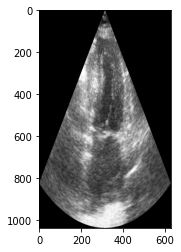

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
load_camus_mhd(CAMUS_DIR, 17, "2CH", "ES", True)

---
📓 ***Une image A2C du coeur du patient n°17 à l'instant de fin systole***
---

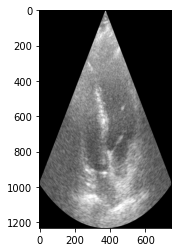

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
load_camus_mhd(CAMUS_DIR, 42, "4CH", "ED", True)

---
📓 ***Une image A4C du coeur du patient n°42 à l'instant de fin diastole***
---


2. Étudiez la fonction "display_mask_camus" puis visualisez les 4 images du patient 17 puis 42 avec les structures annotées. Pourquoi est-ce que la segmentation du coeur est une tâche particulièrement difficile en ultrasons ?



In [ ]:
def display_mask_camus(dataset_path, pid, view, ti, csize=5, display=False):
    """
    :param dataset_path: path to the CAMUS dataset
    :param pid: patient ID number
    :param view: '2CH' or '4CH' view
    :param ti: 'ES' or 'ED' instant
    :param csize: contour size in px
    """

    pid = str(pid).zfill(4)  # put ID on 4 digits
    pname = 'patient' + pid
    data_path = os.path.join(dataset_path, pname)
    im_name = os.path.join(data_path, pname + '_' + view + '_' + ti)
    mask_name = os.path.join(data_path, pname + '_' + view + '_' + ti)

    img = io.imread(im_name + '.mhd', plugin='simpleitk')[0]  # load image with SimpleITK
    mask = io.imread(mask_name + '_gt.mhd', plugin='simpleitk')[0]  # load mask with SimpleITK
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # extract frontier between neighbouring structures
    selem = sk.morphology.disk(csize)  # structuring element
    struct1 = (sk.filters.rank.minimum(mask, selem) == 1) & (sk.filters.rank.maximum(mask, selem) == 2)  # LV
    struct2 = (sk.filters.rank.minimum(mask, selem) == 0) & (sk.filters.rank.maximum(mask, selem) == 2)  # Myocardium
    struct3 = (sk.filters.rank.minimum(mask, selem) == 0) & (sk.filters.rank.maximum(mask, selem) == 3)  # LA

    # associate each structure to a color
    img[struct1, :] = np.asarray([255, 0, 0])
    img[struct2, :] = np.asarray([0, 255, 0])
    img[struct3, :] = np.asarray([0, 0, 255])

    # Show result
    if display:
        plt.figure()
        plt.imshow(img)
        plt.show(block=False)
        plt.savefig(im_name + 'with_mask.png')
    return mask

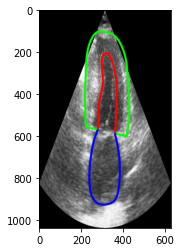

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mask_camus(CAMUS_DIR, 17, "2CH", "ES", display=True)

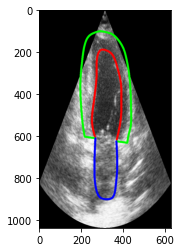

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mask_camus(CAMUS_DIR, 17, "2CH", "ED", display=True)

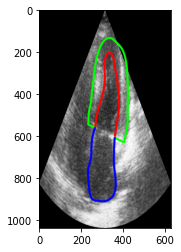

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mask_camus(CAMUS_DIR, 17, "4CH", "ES", display=True)

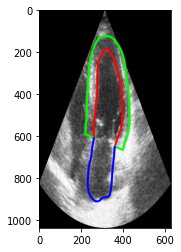

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mask_camus(CAMUS_DIR, 17, "4CH", "ED", display=True)



---



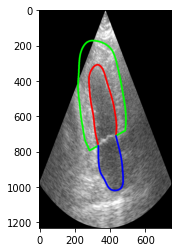

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mask_camus(CAMUS_DIR, 42, "2CH", "ES", display=True)

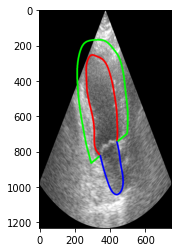

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mask_camus(CAMUS_DIR, 42, "2CH", "ED", display=True)

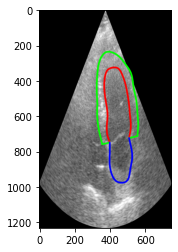

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mask_camus(CAMUS_DIR, 42, "4CH", "ES", display=True)

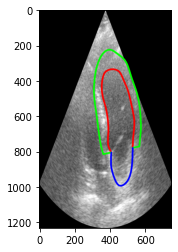

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

<Figure size 432x288 with 0 Axes>

In [ ]:
display_mask_camus(CAMUS_DIR, 42, "4CH", "ED", display=True)

---
📓 ***Les images obtenues sont de basse résolution et ont beaucoup de bruit***
---
📓 ***L'apparence du coeur peut varier considérablement d’une personne à l’autre***
---
📓 ***L'annotation manuelle du cœur dans les images échographiques est une tâche longue et laborieuse.***
---

3. Chargez les images 2CH des patients 17, 42, 256 et 326. Comparez les valeurs minimales et maximales des images ainsi que leur taille. Que constatez-vous ?

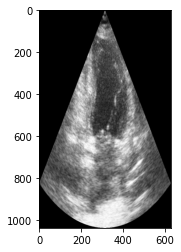

<Figure size 432x288 with 0 Axes>

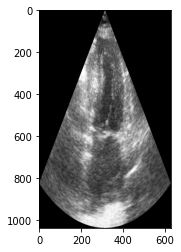

<Figure size 432x288 with 0 Axes>

In [ ]:
seventeen_ed  = load_camus_mhd(CAMUS_DIR, 17, "2CH", "ED", True)
seventeen_es  = load_camus_mhd(CAMUS_DIR, 17, "2CH", "ES", True)

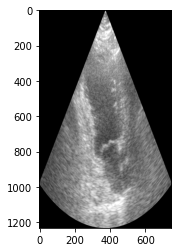

<Figure size 432x288 with 0 Axes>

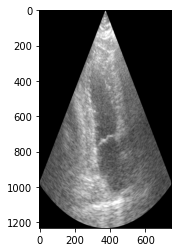

<Figure size 432x288 with 0 Axes>

In [ ]:
fortytwo_ed  = load_camus_mhd(CAMUS_DIR, 42, "2CH", "ED", True)
fortytwo_es  = load_camus_mhd(CAMUS_DIR, 42, "2CH", "ES", True)

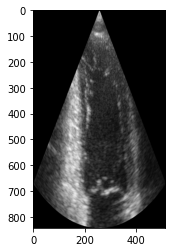

<Figure size 432x288 with 0 Axes>

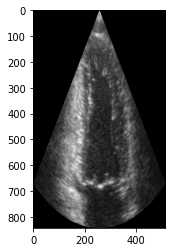

<Figure size 432x288 with 0 Axes>

In [ ]:
twofiftysix_ed  = load_camus_mhd(CAMUS_DIR, 256, "2CH", "ED", True)
twofiftysix_es  = load_camus_mhd(CAMUS_DIR, 256, "2CH", "ES", True)

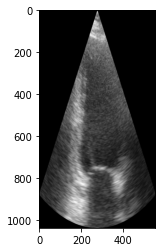

<Figure size 432x288 with 0 Axes>

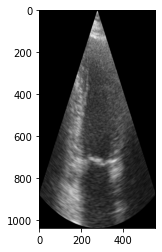

<Figure size 432x288 with 0 Axes>

In [ ]:
threetwenysix_ed  = load_camus_mhd(CAMUS_DIR, 326, "2CH", "ED", True)
threetwenysix_es  = load_camus_mhd(CAMUS_DIR, 326, "2CH", "ES", True)

---
📓 ***Les images ont toutes une intensité différente et la coupe n'est pas stable/unifié***
---

4. Utilisez la fonction "intensity_and_size_equalization" pour harmoniser les images en terme d'intensité et de dimensions. Expliquez pourquoi cette étape est primordiale en particulier dans l'optique d'utiliser des méthodes d'apprentissage. 

In [ ]:
def intensity_and_size_equalization(img, size, display=False):
    """
    :param img: image to pre-process
    :param size : target size
    :return: the pre-processed image
    """

    img = sk.transform.resize(img, size, order=1)  # resize image with bilinear interpolation
    img_out = 255 * (img - np.min(img)) / (np.max(img) - np.min(img))  # intensity normalization on uint8 images

    # Show result
    if display:
        plt.figure()  # display
        plt.imshow(img, cmap='gray')
        plt.show(block=False)
    return np.uint8(img_out)

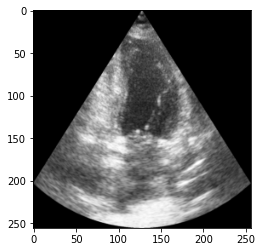

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
intensity_and_size_equalization(load_camus_mhd(CAMUS_DIR, 17, "2CH", "ED"), (256, 256), True)





---
📓  ***Si l’intensité varie considérablement, il peut être plus difficile pour le modèle d’apprendre avec précision les features qui sont importantes pour faire des prédictions, cela aide également à réduire la compléxité du modèle et donc gagner du temps lors de l'entrainement***
---




#### Débruitage à base d'ondelettes ####

La texture des images ultrasonores, appelée "speckle", est souvent assimilée à du bruit rendant la détection de contours difficile. Une des solutions communément adoptée pour l'atténuer est le débruitage par ondelettes (le speckle est alors assimilé à un bruit gaussien), qui donne de meilleurs résultats qu'un simple filtre passe-bas.

5. Étudiez la fonction "us_denoising" puis appliquez la avec les paramètres par défaut sur l'image 2CH du patient 256 en ES. Qu'observez-vous ? 



In [ ]:
def us_denoising(img, method='median', scale=5, display=False):
    """
    :param img: image to filter
    :param method : type of filters 'wavelets' or median filter by default
    :return: the filtered image
    """

    if method == 'wavelets':

        sigma = estimate_sigma(img)  # Estimate the average noise standard deviation across color channels.
        img_out = denoise_wavelet(img, sigma=scale * sigma, wavelet='db2',
                                  method='BayesShrink')  # Use orthogonal wavelets (db)

    else:

        # return local median of an image
        selem = sk.morphology.disk(scale)  # structuring element
        img_out = median(img, selem)

    # Show result
    if display:
        plt.figure()  # display
        plt.imshow(img_out, cmap='gray')
        plt.show(block=False)
    return img_out


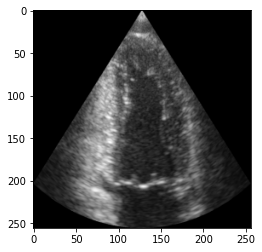

In [ ]:
eq_img = intensity_and_size_equalization(load_camus_mhd(CAMUS_DIR, 256, "2CH", "ES"), (256, 256), True)

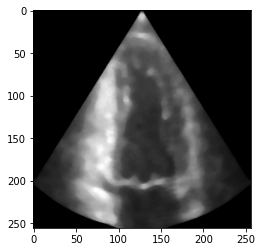

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
us_denoising(eq_img, display=True)

---
📓 ***L'image fini par devenir très floue avec les paramètres par default de la fonction***
---

6. Jouez avec les paramètres jusqu'à obtenir une configuration qui vous semble donner de bons résultats de filtrage du speckle dans le ventricule gauche. Comment procéderiez-vous pour trouver la valeur optimale de ces hyper-paramètres sur toute la base de données ? 

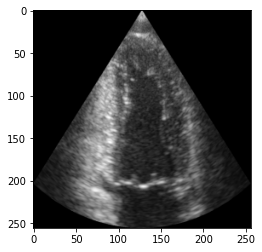

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
intensity_and_size_equalization(load_camus_mhd(CAMUS_DIR, 256, "2CH", "ES"), (256, 256), True)

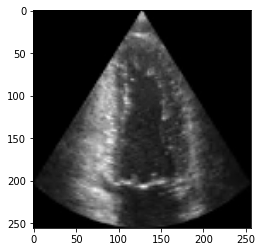

In [ ]:
dns_img = us_denoising(eq_img, display=True, method='wavelets')

Scale: 1


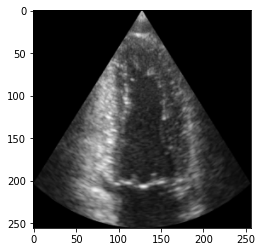

Scale: 2


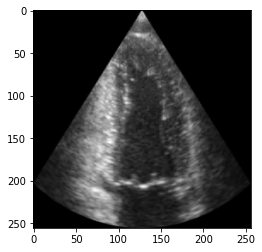

Scale: 3


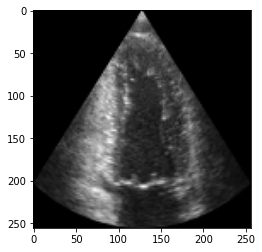

Scale: 4


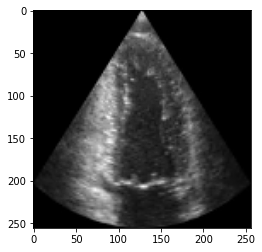

Scale: 5


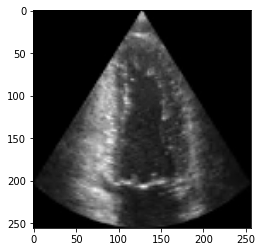

Scale: 6


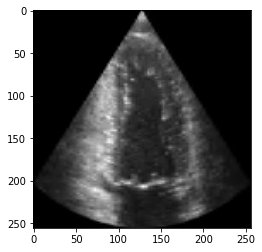

Scale: 7


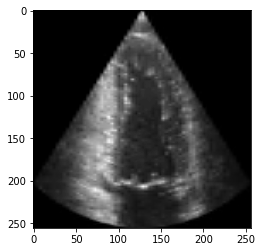

Scale: 8


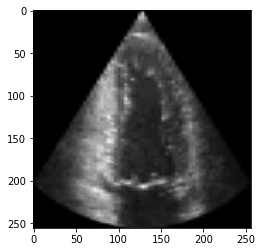

Scale: 9


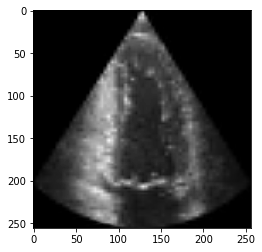

In [ ]:
for i in range(1,10):
  print("Scale:", i)
  us_denoising(eq_img, 'wavelets', i, True)

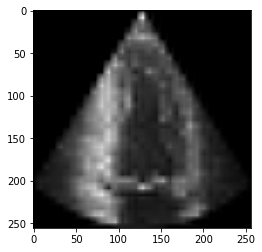

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
us_denoising(eq_img, 'wavelets', 100, True)

---
📓 ***Une approche serait en spécifiant une liste de valeurs pour chaque hyperparamètre, puis en évaluant le modèle pour chaque combinaison de valeurs d’hyperparamètres selon une métrique qui reflète le résultat recherché***
---

#### Application à l' extraction de caractéristiques de bords ####


L'histogramme de gradients orientés (HOG) est une caractéristique très utilisée pour la détection d'objets en vision par ordinateur, dans laquelle un bord n'est pas seulement associé à une intensité mais également à une direction.

7. Étudiez la fonction "HOG" avant de l'appliquer sur l'image 2CH du patient 256 sans débruitage, puis après débruitage. Qu'observez-vous ?


In [ ]:
def compute_hog(img, orientations=4, patch_size=(16, 16), display=True):
    """
    :param img: image to extract features from
    :param orientations : number of orientations to consider
    :return: the HOG features (we won't use them though)
    """

    # creating hog features
    fd, hog_image = hog(img, orientations, patch_size, visualize=True)

    if display:
        plt.figure()  # display
        plt.imshow(hog_image, cmap='gray')
        plt.show(block=False)
    return fd

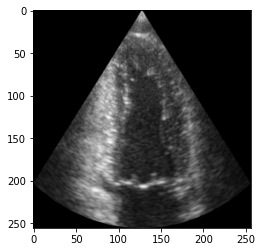

In [ ]:
plt.figure()  # display
plt.imshow(eq_img, cmap='gray')
plt.show(block=False)

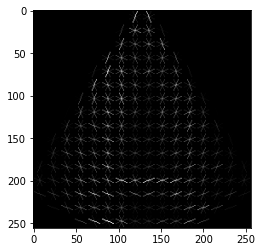

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
compute_hog(eq_img)

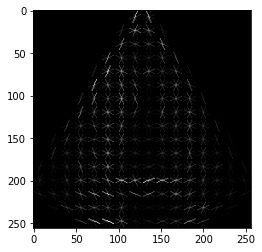

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.61645017e-06, 7.11458637e-06, 3.51798326e-06])

In [ ]:
compute_hog(dns_img)



---
📓 ***Les contours sont beaucoup moins accentué sur l'image débruité (ex: les contours à l'intérieure du ventricule)***
---

8. Affichez les HOG calculés en changeant la taille du patch. Selon vous, quelles échelles apparaissent comme les plus utiles pour détecter le ventricule gauche ?



Patch Size: ( 2  +  2 )


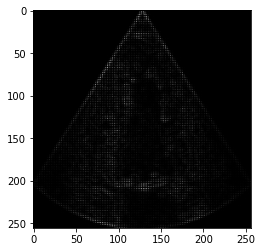

Patch Size: ( 4  +  4 )


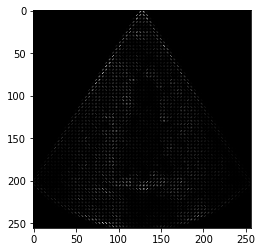

Patch Size: ( 8  +  8 )


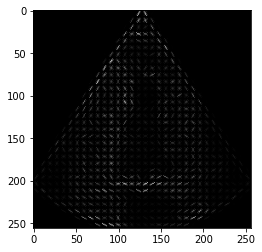

Patch Size: ( 16  +  16 )


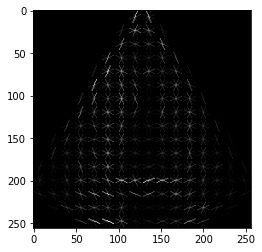

Patch Size: ( 32  +  32 )


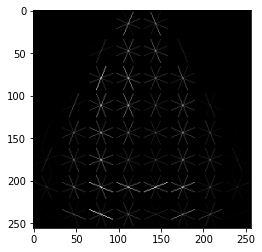

Patch Size: ( 64  +  64 )


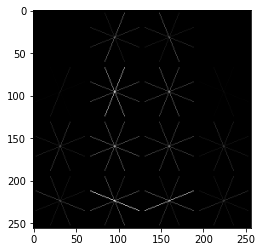

In [ ]:
for i in [2, 4, 8, 16, 32, 64]:
  print("Patch Size: (", i, ' + ', i, ')')
  compute_hog(dns_img, patch_size=(i, i))

Patch Size: ( 8 ,  8 )


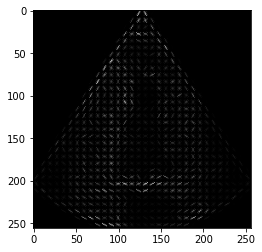

Patch Size: ( 10 ,  10 )


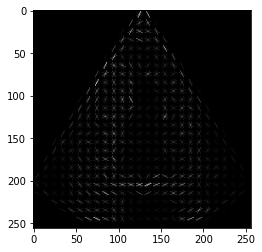

Patch Size: ( 12 ,  12 )


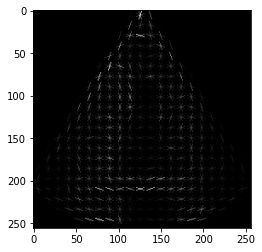

Patch Size: ( 14 ,  14 )


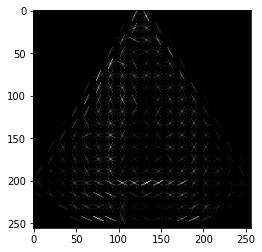

Patch Size: ( 16 ,  16 )


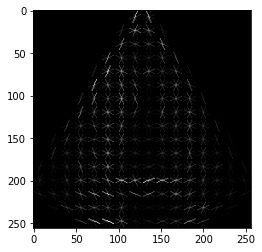

Patch Size: ( 18 ,  18 )


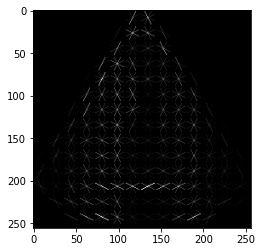

Patch Size: ( 20 ,  20 )


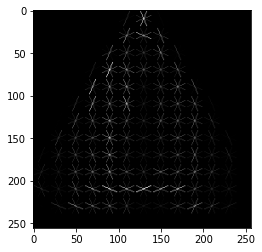

In [ ]:
for i in [8, 10, 12, 14, 16, 18, 20]:
  print("Patch Size: (", i, ', ', i, ')')
  compute_hog(dns_img, patch_size=(i, i))



---
📓 ***Les échèlles (8,8), (10,10) et (12,12) délimite plus clairement le ventricule gauche*** 
---

#### Extraction de régions d'intérêt ####

Il est commun en imagerie médicale de concentrer le traitement autour d'une zone d'intérêt (ROI) afin d'améliorer la précision, que ce soit pour de la détection, segmentation ou classification. En effet cela permet de normaliser le context et de s'affranchir d'une variabilité qui pourrait confondre les algorithmes. 

9. En utilisant la fonction extract_roi, proposez un algorithme permettant d'isoler le ventricule gauche (label=1) avec une marge de 10 px sur une image de CAMUS. 


In [ ]:
def extract_roi(img, mask, label=2, margin=0, display=False):
    """
    :param img: image to extract features from
    :param mask : masque de segmentation
    :param label : Structure to extract
    :param margin : margin in px
    :return: the ROI
    """

    # get the bounding box coordinates
    mask[mask != label] = 0  # isolate structure
    mask = sk.transform.resize(mask, img.shape, order=0)  # resize with nearest neighbour interpolation
    edge_ind = np.argwhere(mask > 0)
    xmin, xmax = np.min(edge_ind[:, 0]), np.max(edge_ind[:, 0])
    ymin, ymax = np.min(edge_ind[:, 1]), np.max(edge_ind[:, 1])

    # apply margin and check image limits
    ds = int(margin / 2)
    xmin, xmax = xmin - ds, xmax + ds
    ymin, ymax = ymin - ds, ymax + ds
    xmin, xmax = np.max([0, xmin]), np.min([xmax, img.shape[0] - 1])
    ymin, ymax = np.max([0, ymin]), np.min([ymax, img.shape[1] - 1])

    roi = img[xmin:xmax, ymin:ymax]

    if display:
        plt.figure()  # display
        plt.imshow(roi, cmap='gray')
        plt.show(block=False)
    return

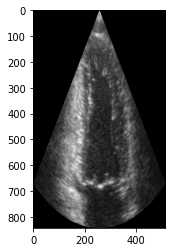

<Figure size 432x288 with 0 Axes>

In [ ]:
img = load_camus_mhd(CAMUS_DIR, 256, "2CH", "ES", True)

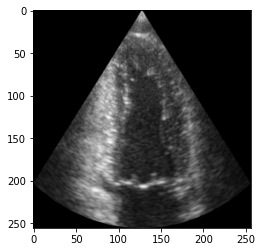

In [ ]:
plt.figure()  # display
plt.imshow(eq_img, cmap='gray')
plt.show(block=False)

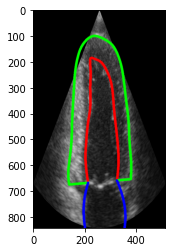

<Figure size 432x288 with 0 Axes>

In [ ]:
mask = display_mask_camus(CAMUS_DIR, 256, "2CH", "ES", display=True)

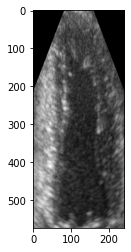

In [ ]:
extract_roi(img, mask, display=True)

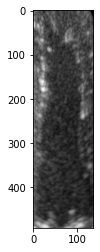

In [ ]:
img = load_camus_mhd(CAMUS_DIR, 256, "2CH", "ES")
mask = display_mask_camus(CAMUS_DIR, 256, "2CH", "ES")
extract_roi(img, mask, 1, 10, True)

10. Comment procéderiez-vous si vous n'aviez pas accès aux masques de segmentation ? 

---
📓 ***Étant donné que nous possédons déjà des fonctions de prétraitement il serait simple d'entrainer un modèle pour détecter une zone particulière du coeur ou pour segmenter celui-ci***
---
*   Nous avons d’images échocardiographiques annoter de ventricule gauche.
*   Nous avons déja des fonctions de préprocessing pour la normalisation de l’intensité, la réduction du bruit et le rééchantillonnage
*   Nous pourrions entrainer un CNN à détecter les ventricules gauches grâce au dataset après preprocessing
---

11. Selon le temps qu'il vous reste, vous pouvez proposer une étape supplémentaire de pré-traitement de ces données.

---
📓 ***Une étape de prétraitement en plus serait de faire de la Data Augmentation sur le dataset (Translation, Rotation, Scaling) afin de s'assurer que le modèle generalise mieux et n'overfit pas***
---